In [1]:
import geometric
import numpy as np
import veloxchem as vlx
from matplotlib import pyplot as plt

In [2]:
molecule_string = """3
water                                                                                                                          
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.895700000000       -0.316700000000                         
H    0.000000000000        0.000000000000        1.100000000000
"""
molecule = vlx.Molecule.read_xyz_string(molecule_string)
basis = vlx.MolecularBasis.read(molecule, "sto-3g", ostream=None)

In [3]:
molecule.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
# Energy
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.ostream.mute()

scf_results = scf_drv.compute(molecule, basis)
energy = scf_drv.get_scf_energy()

In [5]:
# Gradient
grad_drv = vlx.ScfGradientDriver(scf_drv)
grad_drv.ostream.mute()

grad_results = grad_drv.compute(molecule, basis, scf_results)
gradient = grad_drv.gradient

In [6]:
# Hessian
hess_drv = vlx.ScfHessianDriver(scf_drv)
hess_drv.ostream.mute()

hess_results = hess_drv.compute(molecule, basis)
hessian = hess_drv.hessian

In [7]:
#            O-H1    O-H2   H1-O-H2
z_matrix = [[0, 1], [0, 2], [1, 0, 2]]

internal_coordinates = []

for z in z_matrix:
    if len(z) == 2:
        # define a bond distance object
        q = geometric.internal.Distance(z[0], z[1])

    elif len(z) == 3:
        # define a bond angle object
        q = geometric.internal.Angle(z[0], z[1], z[2])

    else:
        # define a dihedral angle object
        q = geometric.internal.Dihedral(z[0], z[1], z[2], z[3])

    internal_coordinates.append(q)

In [8]:
def get_b_matrix(molecule, internal_coordinates, z_matrix):
    n_atoms = molecule.number_of_atoms()

    # number of Cartesian coordinates
    n_cart = 3 * n_atoms

    # number of internal coordinates
    n_int = len(internal_coordinates)

    # initialize the B-matrix
    b_matrix = np.zeros((n_int, n_cart))

    # Cartesian coordinates
    coords = molecule.get_coordinates_in_bohr().reshape(3 * n_atoms)

    # calculate the derivatives of q with respect to coords
    i = 0  # i runs over all the internal coordinates
    for q in internal_coordinates:
        deriv_q = q.derivative(coords)
        # add the derivative values in the right spots of the b_matrix;
        # we need the atom indices from the Z-matrix.
        for a in z_matrix[i]:
            # from 3 * atom_index to 3 * atom_index + 3
            b_matrix[i, 3 * a : 3 * a + 3] = deriv_q[a]
        i += 1
    return b_matrix


b_mat = get_b_matrix(molecule, internal_coordinates, z_matrix)

In [9]:
g_mat = np.matmul(b_mat, b_mat.T)

In [10]:
g_val, g_vec = np.linalg.eig(g_mat)
g_val_inverse = []
for g in g_val:
    if abs(g) > 1e-7:
        g_val_inverse.append(1.0 / g)
    else:
        g_val_inverse.append(0.0)
g_val_inverse_mat = np.diag(np.array(g_val_inverse))
g_minus = np.linalg.multi_dot([g_vec, g_val_inverse_mat, g_vec.T])

In [11]:
def get_g_minus(b_matrix):
    g_mat = np.matmul(b_matrix, b_matrix.T)
    g_val, g_vec = np.linalg.eig(g_mat)
    g_val_inverse = []
    for g in g_val:
        if abs(g) > 1e-7:
            g_val_inverse.append(1.0 / g)
        else:
            g_val_inverse.append(0.0)

    g_val_inverse_mat = np.diag(np.array(g_val_inverse))
    g_minus = np.linalg.multi_dot([g_vec, g_val_inverse_mat, g_vec.T])

    return g_minus


g = get_g_minus(b_mat)

In [12]:
def get_b2_matrix(molecule, internal_coordinates, z_matrix):
    n_atoms = molecule.number_of_atoms()

    # number of Cartesian coordinates
    n_cart = 3 * n_atoms

    # number of internal coordinates
    n_int = len(internal_coordinates)

    # initialize the B-matrix
    b2_matrix = np.zeros((n_int, n_cart, n_cart))

    # Cartesian coordinates
    coords = molecule.get_coordinates_in_bohr().reshape(3 * n_atoms)

    # calculate the derivatives of q with respect to coords
    i = 0  # i runs over all the internal coordinates
    for q in internal_coordinates:
        second_deriv_q = q.second_derivative(coords)
        # add the derivative values in the right spots of the b_matrix;
        # we need the atom indices from the Z-matrix.
        for a in z_matrix[i]:
            for b in z_matrix[i]:
                # from 3 * atom_index_a to 3 * atom_index_a + 3
                # and from 3 * atom_index_b to 3 * atom_index_b + 3
                b2_matrix[i, 3 * a : 3 * a + 3,
                             3 * b : 3 * b + 3] = (
                                 second_deriv_q[a, :, b, :]
                             )
        i += 1
    return b2_matrix


b2_matrix = get_b2_matrix(molecule, internal_coordinates, z_matrix)

In [13]:
def convert_gradient_to_internal(gradient, b_matrix, g_minus):
    n_atoms = gradient.shape[0]

    # reshape the Cartesian gradient to match the dimensions of the
    # g_minus and b_matrix
    grad_x = gradient.reshape((3 * n_atoms))

    # convert to internal coordinates
    grad_q = np.linalg.multi_dot([g_minus, b_matrix, grad_x])
    return grad_q


grad_q = convert_gradient_to_internal(gradient, b_mat, g_minus)

# To check if the gradient in internal coordinates is correct, you can calculate selected elements numerically.

In [14]:
def convert_Hessian_to_internal(hessian, b_matrix, g_minus, b2_matrix, grad_q):
    # calculate term related to the second order B-matrix
    gradq_b2mat = np.einsum("i,ixy->xy", grad_q, b2_matrix)

    # convert the Hessian from Cartesian to internal coordinates
    hessian_q = np.linalg.multi_dot(
        [g_minus, b_matrix, hessian - gradq_b2mat, b_matrix.T, g_minus.T]
    )
    return hessian_q


hessian_q = convert_Hessian_to_internal(hessian, b_mat, g_minus, b2_matrix, grad_q)

# To check if the conversion of the Hessian works correctly
# you can calculate selected Hessian matrix elements numerically.

In [15]:
mol_template = """                                                                                                              
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.895700000000       -0.316700000000                         
H    0.000000000000        0.000000000000        OHdist
"""

# list of bond distances
distlist = [0.75, 0.95, 1.35]

In [16]:
# empty list to save the energies, gradients and hessians
energies = []
cart_gradients = []
cart_hessians = []

# list for molecular configurations
molecules = []

for oh in distlist:
    print("Calculating the energies, gradients and Hessians for OH = ", oh, "A...")

    # Create new molecule
    mol_str = mol_template.replace("OHdist", str(oh))
    new_molecule = vlx.Molecule.read_molecule_string(mol_str, units="angstrom")

    # set-up an scf driver
    new_scf_drv = vlx.ScfRestrictedDriver()
    new_scf_drv.ostream.mute()
    new_scf_results = new_scf_drv.compute(new_molecule, basis)

    # calculate the gradient
    new_scf_grad_drv = vlx.ScfGradientDriver(new_scf_drv)
    new_scf_grad_drv.ostream.state = False
    new_scf_grad_drv.compute(new_molecule, basis)

    # calculate the Hessian
    new_scf_hessian_drv = vlx.ScfHessianDriver(new_scf_drv)
    new_scf_hessian_drv.ostream.state = False
    new_scf_hessian_drv.compute(new_molecule, basis)

    # save the results:
    energy = new_scf_drv.get_scf_energy()
    cart_gradient = new_scf_grad_drv.gradient
    cart_hessian = new_scf_hessian_drv.hessian

    energies.append(energy)
    cart_gradients.append(cart_gradient)
    cart_hessians.append(cart_hessian)
    molecules.append(new_molecule)

Calculating the energies, gradients and Hessians for OH =  0.75 A...
Calculating the energies, gradients and Hessians for OH =  0.95 A...


Calculating the energies, gradients and Hessians for OH =  1.35 A...


In [17]:
# number of data points:
n_data_pts = len(energies)

# empty lists for the internal gradients and Hessians:
int_gradients = []
int_hessians = []

for i in range(n_data_pts):
    grad_x = cart_gradients[i]
    hess_x = cart_hessians[i]
    mol = molecules[i]
    b_mat = get_b_matrix(mol, internal_coordinates, z_matrix)
    g_minus = get_g_minus(b_mat)
    b2_mat = get_b2_matrix(mol, internal_coordinates, z_matrix)

    grad_q = convert_gradient_to_internal(grad_x, b_mat, g_minus)
    hess_q = convert_Hessian_to_internal(hess_x, b_mat, g_minus, b2_mat, grad_q)
    int_gradients.append(grad_q)
    int_hessians.append(hess_q)

In [18]:
def get_harmonic_potential(q_a, e_a, g_a, h_a, new_q):
    # coords_a are the coordinates where the energy, gradient and
    # hessian have been calculated;
    dist = new_q - q_a
    pot = e_a + np.matmul(dist.T, g_a) + 0.5 * np.linalg.multi_dot([dist.T, h_a, dist])
    return pot

In [19]:
def get_internal_coordinates_array(internal_coordinates, cart_coords):
    q_list = []
    for q in internal_coordinates:
        q_list.append(q.value(cart_coords))
    return np.array(q_list)


# list of internal coordinates with our interpolation data points:
qs = []

for molec in molecules:
    cart_coords = molec.get_coordinates_in_bohr()
    q_a = get_internal_coordinates_array(internal_coordinates, cart_coords)
    qs.append(q_a)

In [20]:
distlist = np.arange(0.6, 2.0, 0.05)

# list of harmonic potentials
harmonic_potentials = []

for i in range(n_data_pts):
    q_a = qs[i]
    e_a = energies[i]
    g_a = int_gradients[i]
    h_a = int_hessians[i]

    potential = []

    for oh in distlist:
        # print("Calculating the harmonic potential for... ", oh)

        # Create new molecule
        mol_str = mol_template.replace("OHdist", str(oh))
        new_molecule = vlx.Molecule.read_molecule_string(mol_str, units="angstrom")
        cart_coords = new_molecule.get_coordinates_in_bohr()
        q = get_internal_coordinates_array(internal_coordinates, cart_coords)

        # Calculate harmonic potential at point q
        pot = get_harmonic_potential(q_a, e_a, g_a, h_a, q)
        potential.append(pot)
    harmonic_potentials.append(np.array(potential))

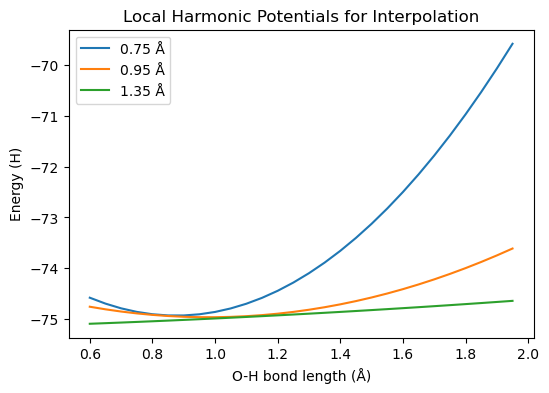

In [21]:
plt.figure(figsize=(6, 4))
plt.title("Local Harmonic Potentials for Interpolation")
plt.plot(distlist, harmonic_potentials[0], label="0.75 Å")
plt.plot(distlist, harmonic_potentials[1], label="0.95 Å")
plt.plot(distlist, harmonic_potentials[2], label="1.35 Å")

plt.xlabel("O-H bond length (Å)")
plt.ylabel("Energy (H)")

plt.legend()
plt.show()

In [22]:
def get_interpolated_pes(
    new_point, data_points, energies, gradients, hessians, exponent
):
    # sum of all interpolation weights -- to normalize them
    sum_weights = 0
    weights = []
    potentials = []

    n_points = len(data_points)

    for i in range(n_points):
        q_a = data_points[i]
        e_a = energies[i]
        g_a = gradients[i]
        h_a = hessians[i]
        dist = np.linalg.norm(new_point - q_a)
        weight = 1 / dist**exponent
        pot = get_harmonic_potential(q_a, e_a, g_a, h_a, new_point)
        # print(pot)
        sum_weights += weight
        weights.append(weight)
        potentials.append(pot)

    new_energy = 0
    for i in range(len(data_points)):
        new_energy += weights[i] / sum_weights * potentials[i]
        # print(en)

    return new_energy

In [23]:
scf_energies = []
im_energies = []

for oh in distlist:

    # Create new molecule
    mol_str = mol_template.replace("OHdist", str(oh))
    new_molecule = vlx.Molecule.read_molecule_string(mol_str, units="angstrom")

    # set-up an xtb driver, gradient driver and hessian driver
    new_scf_drv = vlx.ScfRestrictedDriver()
    new_scf_drv.ostream.state = False
    new_scf_results = new_scf_drv.compute(new_molecule, basis)

    # save the results:
    energy = new_scf_drv.get_scf_energy()

    scf_energies.append(energy)

    # calculate energies by interpolation
    coords = new_molecule.get_coordinates_in_bohr()
    new_q = get_internal_coordinates_array(internal_coordinates, coords)
    im_energy = get_interpolated_pes(
        new_q, qs, energies, int_gradients, int_hessians, 12
    )

    im_energies.append(im_energy)

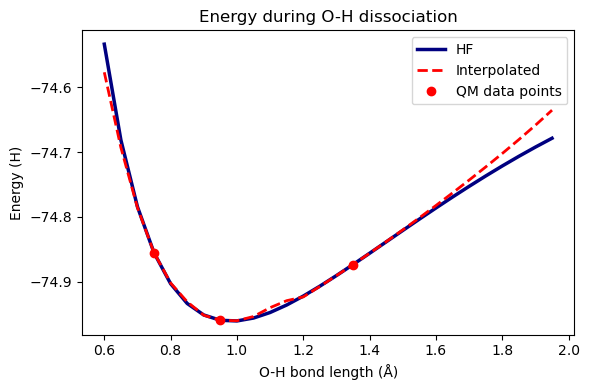

In [24]:
qm_points = [0.75, 0.95, 1.35]

plt.figure(figsize=(6, 4))
plt.title("Energy during O-H dissociation")
plt.plot(distlist, scf_energies, label="HF", linewidth=2.5, color="navy")
plt.plot(distlist, im_energies, "--", label="Interpolated", linewidth=2, color="red")
plt.plot(qm_points, energies, "o", label="QM data points", color="red")

plt.xlabel("O-H bond length (Å)")
plt.ylabel("Energy (H)")

plt.legend()
plt.tight_layout()
plt.show()

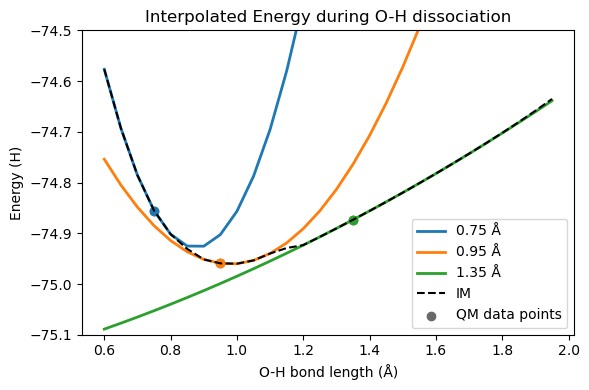

In [25]:
plt.figure(figsize=(6, 4))
plt.title("Interpolated Energy during O-H dissociation")
plt.plot(distlist, harmonic_potentials[0], label="0.75 Å", linewidth=2)
plt.plot(distlist, harmonic_potentials[1], label="0.95 Å", linewidth=2)
plt.plot(distlist, harmonic_potentials[2], label="1.35 Å", linewidth=2)
plt.plot(distlist, im_energies, label="IM", ls="--", color="black")

#plt.plot(qm_points, energies, "o", label="QM data points", color="dimgrey")

plt.scatter(qm_points, energies, label="QM data points", color="dimgrey")
plt.scatter(qm_points[0], energies[0])
plt.scatter(qm_points[1], energies[1])
plt.scatter(qm_points[2], energies[2])

plt.axis(ymin=-75.1, ymax=-74.5)

plt.xlabel("O-H bond length (Å)")
plt.ylabel("Energy (H)")

plt.legend()
plt.tight_layout()
plt.show()